In [1]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("big-data-project-analysis")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 17:42:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load reviews data

This section loads the three pre-split grocery review CSV files into a single Spark DataFrame for analysis.


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = (
    SparkSession.builder
    .appName("big-data-project-analysis")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
    .getOrCreate()
)
base_path = "../data"
df = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv([
        f"{base_path}/grocery_reviews_part1",
        f"{base_path}/grocery_reviews_part2",
        f"{base_path}/grocery_reviews_part3",
    ])
)
df.printSchema()
df.count()
df.show(5, truncate=False)

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



+------+--------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------+----------------------------+-------------+------------+-----------------+
|rating|title                                 |text                                                                                                                                                                                                                                                                                                                                                                

### Feature engineering: review_length and is_positive

Here we create the review_length column based on the number of characters in the review text, and define is_positive as a binary label where ratings of 4 or 5 are treated as positive (1) and lower ratings as non-positive (0).


In [3]:
# From text length
df2 = df.withColumn("review_length", F.length(F.col("text")))
# Positive vs non‑positive
df3 = df2.withColumn(
    "is_positive",
    F.when(F.col("rating") >= 4.0, 1).otherwise(0)
)
df3.printSchema()
df3.select("rating", "review_length", "is_positive").show(5)

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_length: integer (nullable = true)
 |-- is_positive: integer (nullable = false)

+------+-------------+-----------+
|rating|review_length|is_positive|
+------+-------------+-----------+
|   5.0|           59|          1|
|   5.0|          128|          1|
|   5.0|          451|          1|
|   5.0|           12|          1|
|   5.0|           46|          1|
+------+-------------+-----------+
only showing top 5 rows


### Create key review segments

In this section we build filtered DataFrames for important segments such as high-rated vs low-rated reviews, verified purchases, helpful reviews, and combinations like high-rated and verified or low-rated or unhelpful reviews.


In [4]:
high_rating = df3.filter(F.col("rating") >= 4.0)
low_rating = df3.filter(F.col("rating") <= 2.0)
verified = df3.filter(F.col("verified_purchase") == True)
helpful = df3.filter(F.col("helpful_vote") >= 5)
high_and_verified = df3.filter(
    (F.col("rating") >= 4.0) & (F.col("verified_purchase") == True)
)
low_or_unhelpful = df3.filter(
    (F.col("rating") <= 2.0) | (F.col("helpful_vote") == 0)
)
high_rating.show(5)
low_rating.show(5)
verified.show(5)
helpful.show(5)
high_and_verified.show(5)
low_or_unhelpful.show(5)









+------+--------------------+--------------------+----------+-----------+--------------------+-------------+------------+-----------------+-------------+-----------+
|rating|               title|                text|      asin|parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|review_length|is_positive|
+------+--------------------+--------------------+----------+-----------+--------------------+-------------+------------+-----------------+-------------+-----------+
|   5.0|  Excellent!  Yummy!|Excellent!! Yummy...|B00CM36GAQ| B00CM36GAQ|AFKZENTNBQ7A7V7UX...|1587854482395|           0|             true|           59|          1|
|   5.0|   Delicious!!! Yum!|Excellent!  The b...|B074J5WVYH| B0759B7KLH|AFKZENTNBQ7A7V7UX...|1587854400380|           0|             true|          128|          1|
|   5.0|Extremely Delicio...|These are very ta...|B079TRNVHX| B079TRNVHX|AFKZENTNBQ7A7V7UX...|1587853224527|           1|             true|          451|          1|
|   

### Verified vs non-verified purchase behavior

This aggregation compares verified_purchase and non-verified reviews by counting how many reviews each group has and computing the average rating for each group.


In [5]:
verified_stats = (df3
    .groupBy("verified_purchase")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating")
    )
)
verified_stats.show()

+-----------------+------------+------------------+
|verified_purchase|review_count|        avg_rating|
+-----------------+------------+------------------+
|             true|    13176519| 4.139967088424492|
|            false|     1142001|3.9249799255867552|
+-----------------+------------+------------------+



### Product-level review statistics

Here we aggregate reviews by product (asin) to compute review_count, average rating, and average review length for each product.


In [6]:
import pyspark.sql.functions as F
# product_stats: aggregations per product (asin)
product_stats = (
    df3
    .groupBy("asin")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating"),
        F.avg("review_length").alias("avg_review_length")
    )
)
product_stats.show(10)

+----------+------------+------------------+------------------+
|      asin|review_count|        avg_rating| avg_review_length|
+----------+------------+------------------+------------------+
|B01IVT445I|          31|2.5483870967741935|103.25806451612904|
|B00PAGP2F2|          90|3.3333333333333335|152.01123595505618|
|B00Z4ZAMPE|         137| 4.138686131386861|105.07299270072993|
|B01NAXA0J7|         284| 3.852112676056338| 145.6267605633803|
|B07SCHCB3T|          42| 4.238095238095238|187.66666666666666|
|B079LXDK7C|         187|2.5668449197860963| 111.1891891891892|
|B079KW2BWG|           6| 4.666666666666667|              92.0|
|B09ZGL19MZ|           9| 2.888888888888889|             213.0|
|B0071Q5FOW|         306| 3.369281045751634| 147.3861386138614|
|B01MUGPLP2|         351|3.8632478632478633|181.85470085470087|
+----------+------------+------------------+------------------+
only showing top 10 rows


### Identify top-rated products

Using the product statistics, we filter to products with at least 50 reviews and then rank them by average rating (and review_count) to highlight consistently top-rated grocery items.


In [7]:
top_products = (product_stats
    .filter(F.col("review_count") >= 50)
    .orderBy(F.col("avg_rating").desc(), F.col("review_count").desc())
)
top_products.show(50)

+----------+------------+------------------+------------------+
|      asin|review_count|        avg_rating| avg_review_length|
+----------+------------+------------------+------------------+
|B09BK15R9T|          62|               5.0| 240.1290322580645|
|B098FCZ1QX|          51|               5.0|228.76470588235293|
|B01GZU7TMU|          50|               5.0|             67.12|
|B0BSNHGS83|          73| 4.986301369863014| 284.0821917808219|
|B084GPSBTP|          70| 4.985714285714286|122.41428571428571|
|B00H86N9O8|          63| 4.984126984126984|108.34920634920636|
|B017T7D422|          60| 4.983333333333333|            183.95|
|B07F5FDMDS|          55|4.9818181818181815|101.65454545454546|
|B006RTHT2U|          55|4.9818181818181815| 147.6909090909091|
|B08B8NJRLV|          54| 4.981481481481482|124.11111111111111|
|B071WXWP8W|          54| 4.981481481481482| 96.71153846153847|
|B00YM9ZL90|          51| 4.980392156862745|143.13725490196077|
|B07Q7111C9|          51| 4.980392156862

### Monthly review volume and rating trends

This section converts timestamps to calendar dates, groups reviews by year and month, and calculates the number of reviews and average rating per month to study trends over time.


In [19]:
joined = df3.join(product_stats, on="asin", how="left")
joined.select(
    "asin", "rating", "is_positive", "avg_rating", "review_count"
).show(10)


+----------+------+-----------+------------------+------------+
|      asin|rating|is_positive|        avg_rating|review_count|
+----------+------+-----------+------------------+------------+
|B0006TLIG0|   1.0|          0|3.2934362934362933|         259|
|B000GG1O6W|   5.0|          1| 4.635820895522388|         335|
|B000VDWQJY|   5.0|          1| 4.241379310344827|          29|
|B00416T8Q6|   5.0|          1| 4.457413249211356|        1268|
|B004DJ1X8M|   5.0|          1|               4.4|          20|
|B004RTQURM|   5.0|          1| 4.270588235294118|          85|
|B005JDF5OE|   5.0|          1|               5.0|           1|
|B005SWLYIC|   5.0|          1| 3.008695652173913|         230|
|B006D1AQO0|   5.0|          1| 4.382022471910112|          89|
|B009F15OJ2|   5.0|          1|2.5714285714285716|           7|
+----------+------+-----------+------------------+------------+
only showing top 10 rows


In [23]:
df4 = (
    df3
    # timestamp is in milliseconds → convert to seconds before from_unixtime
    .withColumn("review_date", F.from_unixtime(F.col("timestamp") / 1000).cast("date"))
    .withColumn("year_month", F.date_format("review_date", "yyyy-MM"))
)


# df4 = (df3
#     .withColumn("review_date", F.from_unixtime(F.col("timestamp")).cast("date"))
#     .withColumn("year_month", F.date_format("review_date", "yyyy-MM"))
# )

In [24]:
monthly = (df4
    .groupBy("year_month")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating")
    )
    .orderBy("year_month")
)

### Window functions for ranking and running trends

We use Spark window functions to rank products by average rating (with a minimum review threshold) and to compute month-to-month changes and running totals, which reveal how review activity and sentiment evolve over time.


In [25]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, dense_rank, lag, lead, sum as F_sum, avg as F_avg
w_rank = Window.orderBy(F.col("avg_rating").desc())
ranked_products = (product_stats
    .filter(F.col("review_count") >= 50)
    .withColumn("rank", rank().over(w_rank))
    .withColumn("dense_rank", dense_rank().over(w_rank))
)
ranked_products.show(20)

25/12/12 18:40:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+------------+------------------+------------------+----+----------+
|      asin|review_count|        avg_rating| avg_review_length|rank|dense_rank|
+----------+------------+------------------+------------------+----+----------+
|B01GZU7TMU|          50|               5.0|             67.12|   1|         1|
|B098FCZ1QX|          51|               5.0|228.76470588235293|   1|         1|
|B09BK15R9T|          62|               5.0| 240.1290322580645|   1|         1|
|B0BSNHGS83|          73| 4.986301369863014| 284.0821917808219|   4|         2|
|B084GPSBTP|          70| 4.985714285714286|122.41428571428571|   5|         3|
|B00H86N9O8|          63| 4.984126984126984|108.34920634920636|   6|         4|
|B017T7D422|          60| 4.983333333333333|            183.95|   7|         5|
|B006RTHT2U|          55|4.9818181818181815| 147.6909090909091|   8|         6|
|B07F5FDMDS|          55|4.9818181818181815|101.65454545454546|   8|         6|
|B071WXWP8W|          54| 4.981481481481

In [26]:
w_month = Window.orderBy("year_month")
monthly_changes = (monthly
    .withColumn("prev_count", lag("review_count", 1).over(w_month))
    .withColumn("next_count", lead("review_count", 1).over(w_month))
    .withColumn("diff_from_prev", F.col("review_count") - F.col("prev_count"))
)
monthly_changes.show(12)

25/12/12 18:40:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 1

+----------+------------+-----------------+----------+----------+--------------+
|year_month|review_count|       avg_rating|prev_count|next_count|diff_from_prev|
+----------+------------+-----------------+----------+----------+--------------+
|   2000-08|           2|              5.0|      NULL|         3|          NULL|
|   2000-12|           3|4.666666666666667|         2|         1|             1|
|   2001-05|           1|              3.0|         3|         2|            -2|
|   2001-07|           2|              5.0|         1|         2|             1|
|   2001-08|           2|              4.5|         2|         2|             0|
|   2001-09|           2|              5.0|         2|         1|             0|
|   2001-10|           1|              5.0|         2|         1|            -1|
|   2002-01|           1|              3.0|         1|         1|             0|
|   2002-04|           1|              4.0|         1|         2|             0|
|   2002-05|           2|   

In [27]:
w_running = Window.orderBy("year_month") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
monthly_running = (monthly
    .withColumn("running_reviews", F_sum("review_count").over(w_running))
    .withColumn("running_avg_rating", F_avg("avg_rating").over(w_running))
)
monthly_running.show(12)


25/12/12 18:40:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 18:40:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 1

+----------+------------+-----------------+---------------+------------------+
|year_month|review_count|       avg_rating|running_reviews|running_avg_rating|
+----------+------------+-----------------+---------------+------------------+
|   2000-08|           2|              5.0|              2|               5.0|
|   2000-12|           3|4.666666666666667|              5| 4.833333333333334|
|   2001-05|           1|              3.0|              6| 4.222222222222222|
|   2001-07|           2|              5.0|              8| 4.416666666666667|
|   2001-08|           2|              4.5|             10| 4.433333333333334|
|   2001-09|           2|              5.0|             12| 4.527777777777778|
|   2001-10|           1|              5.0|             13| 4.595238095238096|
|   2002-01|           1|              3.0|             14| 4.395833333333334|
|   2002-04|           1|              4.0|             15| 4.351851851851852|
|   2002-05|           2|              5.0|         

### Key insights from the analysis

- Describe how ratings are distributed across 1 to 5 stars and whether reviews are mostly positive.
- Summarize differences between verified and non-verified purchases in terms of volume and average rating.
- Highlight patterns about top products (for example, high rating combined with many reviews).
- Mention any noticeable time trends in review volume or average rating over the months.


### Rating distribution

In this section we examine how review ratings are distributed from 1 to 5 stars. This helps reveal whether the grocery reviews are mostly positive or if there is a substantial share of negative feedback.


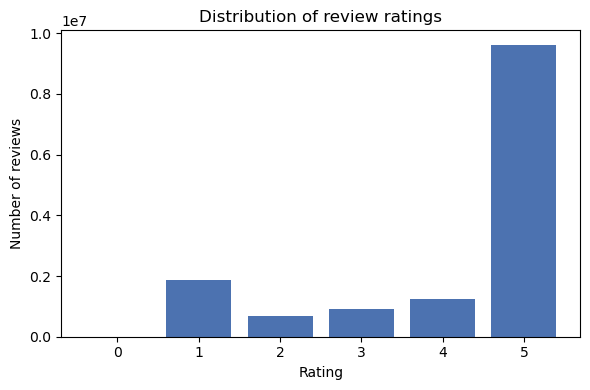

In [28]:
# Rating distribution (count of reviews per rating)
rating_counts = (
    df3.groupBy("rating")
       .count()
       .orderBy("rating")
)

rating_pdf = rating_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(rating_pdf["rating"], rating_pdf["count"], color="#4C72B0")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.title("Distribution of review ratings")
plt.xticks([0, 1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


### Verified vs non-verified purchase ratings

Here we compare verified purchases with non-verified reviews by plotting their average rating and volume. This highlights whether verified buyers tend to rate products differently than other reviewers.


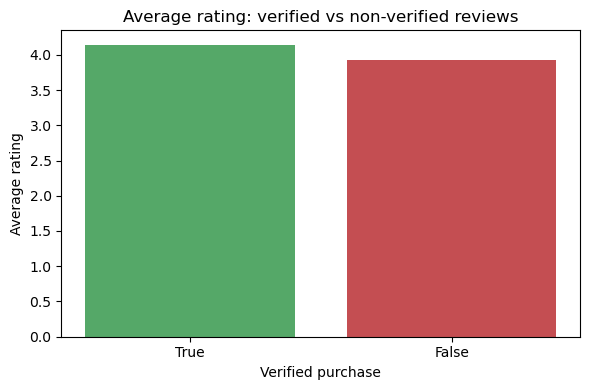

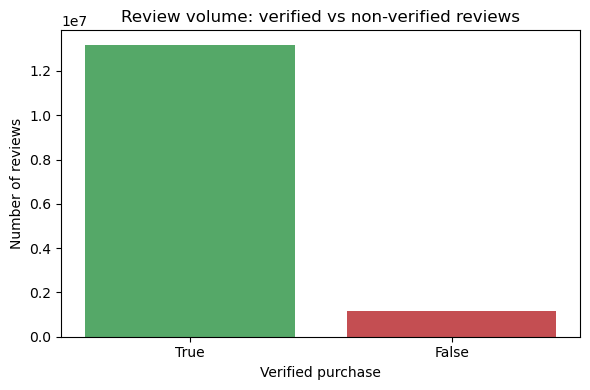

In [29]:
verified_pdf = verified_stats.toPandas()

plt.figure(figsize=(6, 4))
plt.bar(
    verified_pdf["verified_purchase"].astype(str),
    verified_pdf["avg_rating"],
    color=["#55A868", "#C44E52"]
)
plt.xlabel("Verified purchase")
plt.ylabel("Average rating")
plt.title("Average rating: verified vs non-verified reviews")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(
    verified_pdf["verified_purchase"].astype(str),
    verified_pdf["review_count"],
    color=["#55A868", "#C44E52"]
)
plt.xlabel("Verified purchase")
plt.ylabel("Number of reviews")
plt.title("Review volume: verified vs non-verified reviews")
plt.tight_layout()
plt.show()


### Top-rated products with sufficient reviews

Using the product-level statistics, this section visualizes the top products by average rating, restricted to items that have at least 50 reviews. This focuses on products that are both highly rated and well-reviewed.


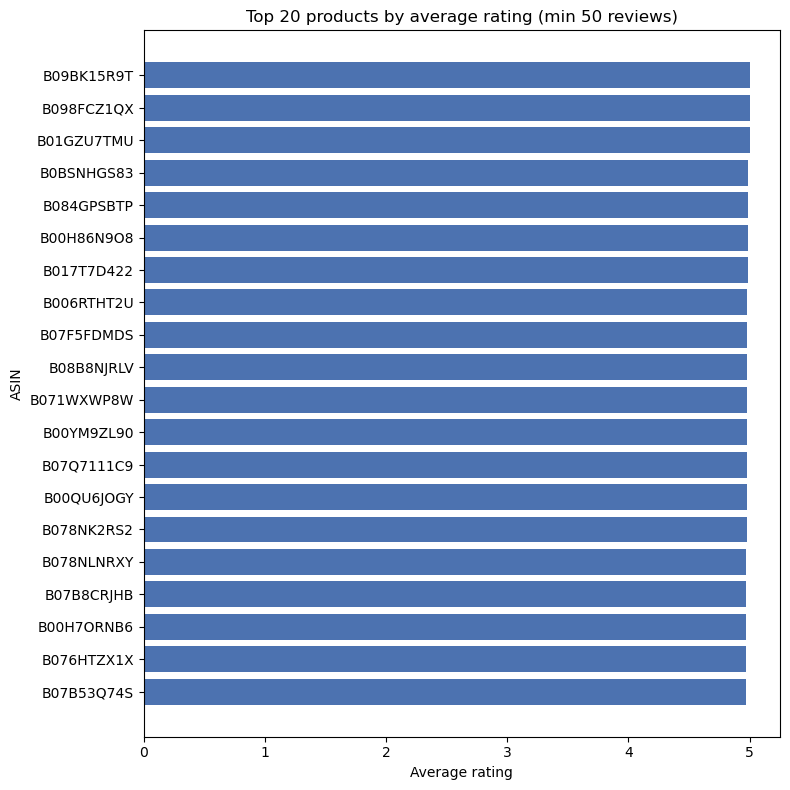

In [34]:
# Use the same filter as before: review_count >= 50, already in top_products
top20_pdf = top_products.limit(20).toPandas()

# Sort for a nicer horizontal bar plot
top20_pdf = top20_pdf.sort_values("avg_rating", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(top20_pdf["asin"], top20_pdf["avg_rating"], color="#4C72B0")
plt.xlabel("Average rating")
plt.ylabel("ASIN")
plt.title("Top 20 products by average rating (min 50 reviews)")
plt.tight_layout()
plt.show()


Yearly review volume and sentiment trends
To understand how customer activity and sentiment change over time, we plot the total number of reviews per year and the average rating per year. This reveals long-term growth or decline in review volume and whether overall ratings are becoming more positive or negative across years.


In [35]:
# Add a year column
df_year = df4.withColumn("year", F.year("review_date"))

yearly = (
    df_year.groupBy("year")
    .agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating")
    )
    .orderBy("year")
)

yearly_pdf = yearly.toPandas()


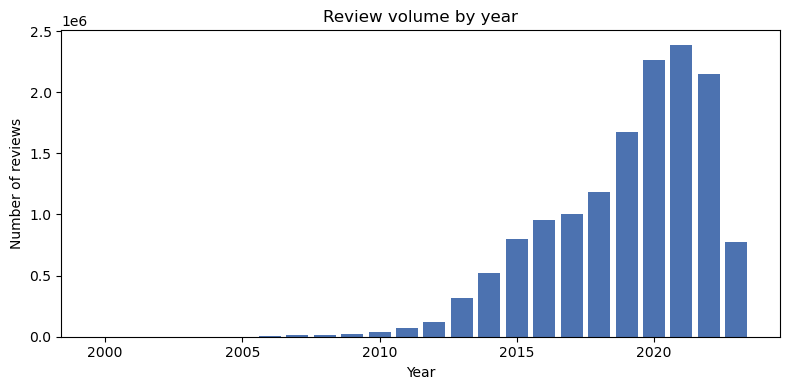

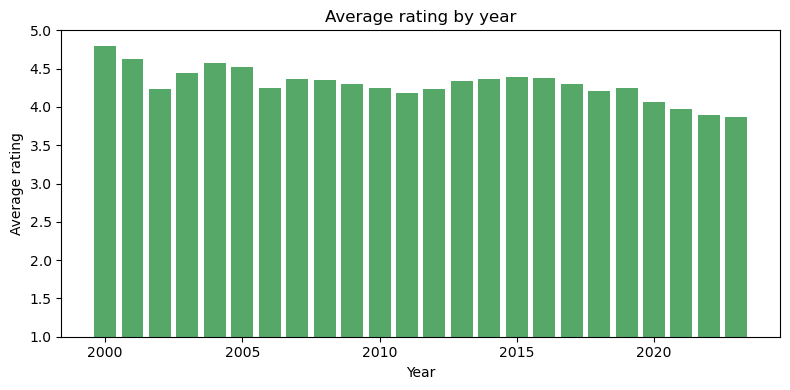

In [36]:
import matplotlib.pyplot as plt

# Reviews per year
plt.figure(figsize=(8,4))
plt.bar(yearly_pdf["year"], yearly_pdf["review_count"], color="#4C72B0")
plt.xlabel("Year")
plt.ylabel("Number of reviews")
plt.title("Review volume by year")
plt.tight_layout()
plt.show()

# Average rating per year
plt.figure(figsize=(8,4))
plt.bar(yearly_pdf["year"], yearly_pdf["avg_rating"], color="#55A868")
plt.xlabel("Year")
plt.ylabel("Average rating")
plt.title("Average rating by year")
plt.ylim(1,5)
plt.tight_layout()
plt.show()


### Key insights from the Spark analysis

- Summarize how ratings are distributed (for example, whether reviews are heavily skewed toward 5 stars or show a mix of positive and negative feedback).
- Describe any differences observed between verified and non-verified purchases in terms of average rating and review volume.
- Highlight what characterizes the top-rated products (such as consistently high ratings combined with many reviews).
- Comment on notable time trends in the monthly review volume and average rating (for example, periods of rapid growth or shifts in sentiment).
- Mention how window-function-based rankings and running metrics helped to identify important products and trends in the grocery reviews.
